In [84]:
import json
import os
import time
from VIPurPCAvsMC import *
from utils import *
import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA as pca_sklearn
from sklearn.datasets import load_iris

def cvp(jvp_fun, vjp_fun, X_flat, X_unflattener, C_flat, n, p, p_keep, i):
    v1 = np.ravel(jax.nn.one_hot(np.array([i]), min(n, p_keep)*p))
    v2 = vjp_fun(v1)[0]
    v3 = np.multiply(v2, C_flat)
    v4 = jvp_fun(v3)
    return v4

def expectation_maximization(Y, n, p, n_samples):
    M = np.mean(Y, axis=0)
    print(M.shape)
    Y = Y - M
    V_0 = np.identity(p)
    U_0 = np.identity(n)
    U_prev = U_0
    V_prev = V_0
    for i in range(1000):
        U_curr = 1/(n_samples*p)*np.sum(vmap(lambda y: np.dot(np.dot(y, np.linalg.inv(V_prev)), y.T))(Y), axis=0)
        V_curr = 1/(n_samples*n)*np.sum(vmap(lambda y: np.dot(np.dot(y.T, np.linalg.inv(U_prev)), y))(Y), axis=0)
        U_curr = U_curr/np.linalg.norm(U_curr, 2)
        V_curr = np.linalg.norm(U_curr, 2)*V_curr
        U_prev = U_curr
        V_prev = V_curr
        if i%100==0:
            print(V_prev)
    return U_curr, V_curr

In [26]:
data = load_iris()

In [27]:
d = data['data']
y = data['target']

In [28]:
y_set = list(set(y))

In [37]:
X_mean = []
X_var = []
for i in y_set:
    X_subset = d[np.where(y==i)]
    mean = np.mean(X_subset, axis=0)
    X_mean.append(mean)
    var = np.var(X_subset, axis=0)
    X_var.append(var)
X_mean = np.array(X_mean)
X_var = np.array(X_var)
#X_var = np.ravel(np.transpose(np.array(X_var)), 'C')

In [38]:
X = X_mean - np.mean(X_mean, axis=0)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
#A = np.load('../data/macrophage/A.npy')
#B = np.load('../data/macrophage/B.npy')
#A = A + 1e-3*np.eye(A.shape[0])
#B = B + 1e-3*np.eye(B.shape[0])
C = X_var
C = np.maximum(C, 1e-6)
C_flat, C_unflattener = flatten_util.ravel_pytree(C)

In [39]:
X

DeviceArray([[-0.8373332 ,  0.37066674, -2.296     , -0.9533332 ],
             [ 0.09266615, -0.2873335 ,  0.5019996 ,  0.12666655],
             [ 0.7446666 , -0.08333349,  1.7939994 ,  0.8266666 ]],            dtype=float32)

In [85]:
p_keep=3
n, p = X.shape
start = time.time()
print('Start PCA')
V = pca(X_flat, X_unflattener, p_keep)
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, C_flat, n, p, p_keep, s)
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C_output = np.vstack([vmap(cvp_fun)(i) for i in b])
end = time.time()
print(end-start)

Start PCA
0.03187131881713867


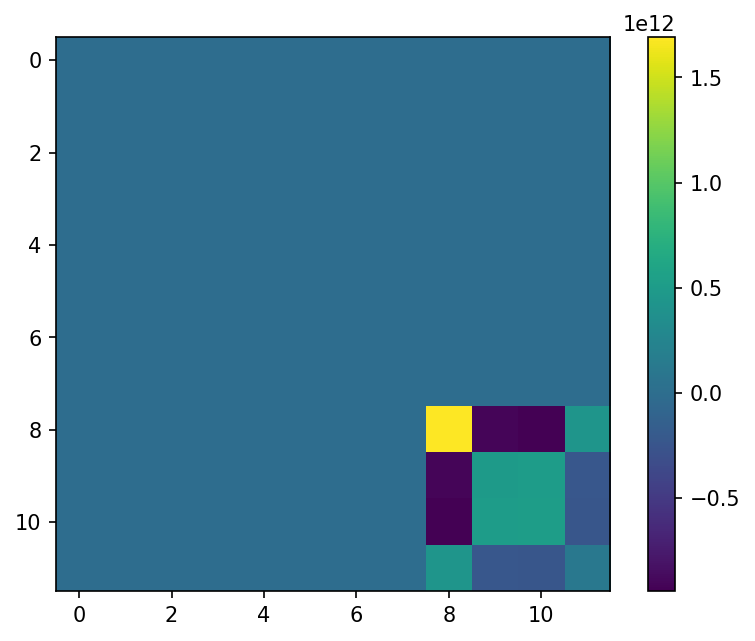

In [86]:
plt.imshow(C_output)
plt.colorbar()

In [81]:
n_iter = 100
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C_output+1e-5*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')) for i in V_drawn])

In [82]:
np.linalg.eigh(C_output)

(DeviceArray([-2.7855782e-08,  1.7373374e-08,  2.8738107e-08,
               3.8500915e-03,  1.4867444e-02,  2.4209017e-02,
               7.8111136e-01,  2.5536630e+00], dtype=float32),
 DeviceArray([[ 3.95167917e-01,  7.35214800e-02, -5.85439336e-03,
               -1.28511444e-01,  7.12126315e-01,  5.60523450e-01,
                6.17395621e-03, -2.32170410e-02],
              [ 3.73444498e-01, -4.89347637e-01,  1.68168500e-01,
               -1.47196665e-01, -5.71333706e-01,  4.94637072e-01,
                6.28922135e-03, -1.70373917e-03],
              [ 5.31636357e-01,  6.61356747e-01, -1.82704717e-01,
               -3.56805980e-01, -3.10768992e-01, -1.50194898e-01,
                8.63525923e-03,  8.24583322e-03],
              [ 4.02787954e-01,  1.22943431e-01, -2.08838340e-02,
                9.03162062e-01, -7.69518763e-02,  4.81733773e-03,
               -2.37421244e-02,  7.58357346e-04],
              [ 1.52295291e-01, -5.31381369e-02,  3.70221317e-01,
               -4.1

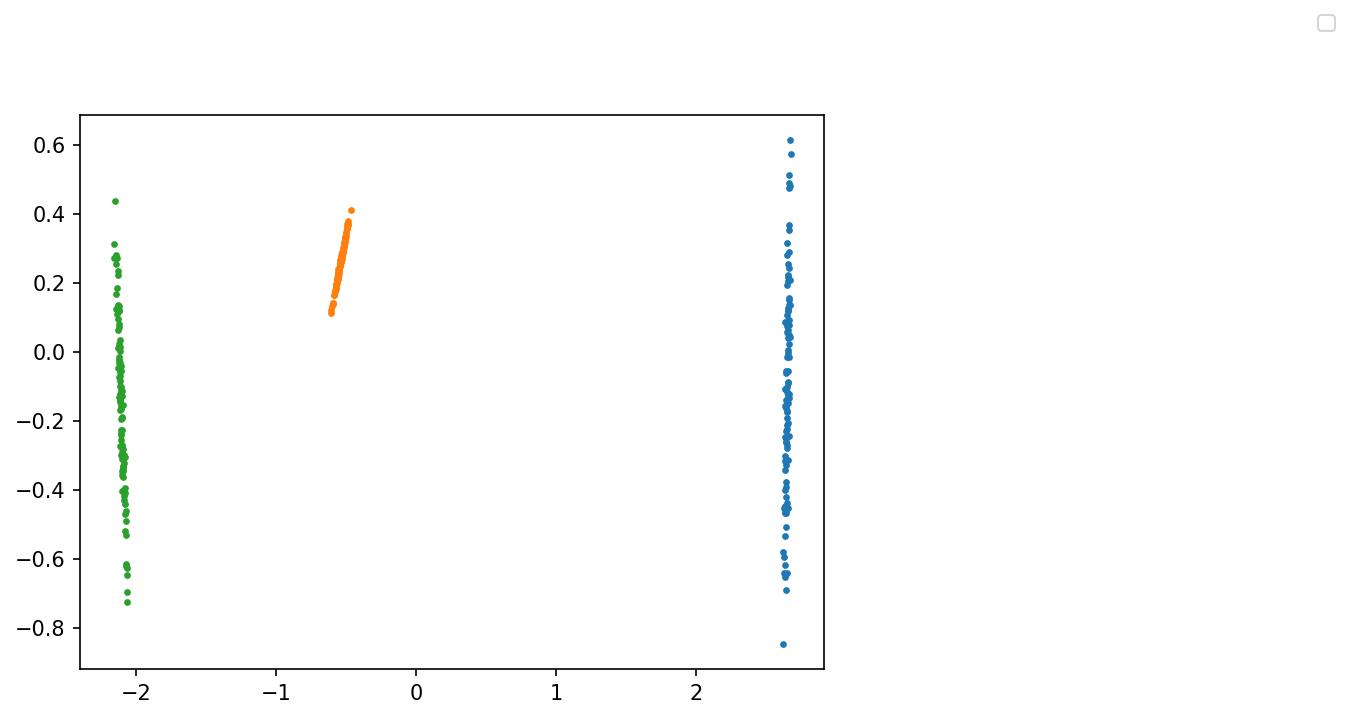

In [83]:
f, ax1 = plt.subplots(1)
pcx, pcy = (0, 1)
for j in range(n):
    ax1.scatter(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=5)#, label=list(d.columns.values)[j], c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
ax1.legend(loc='upper right', bbox_to_anchor=(1.7, 1.2), ncol=2)